# Well Multiphase Production Performance Prediction Using Deep Learning 

## Libraries Loading 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation,GRU
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


##  Data loading and preparation

In [2]:
data =pd.read_excel('data/data_well_f15_r.xlsx', sheet_name= 'Sheet1')

In [3]:
data.head()

,DATEPRD,NPD_WELL_BORE_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,...,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,OIL_RATE,GAS_RATE,WAT_RATE,WAT_CUT,TIME,TIME_INTV,PRESS_INTV
0,2008-07-13,15/9-F-14,24.00,260.866875,103.292880,160.151955,0.0,21.052993,100.714919,52.381899,...,1735.26,252235.23,4.00,1735.260000,252235.230000,4.000000,0.002300,0,0,0.000000
1,2008-07-14,15/9-F-14,5.57,256.248230,104.017718,156.649912,0.0,27.223459,99.598318,71.115352,...,592.36,88949.00,1.37,2552.359066,383263.195691,5.903052,0.002307,1,1,-4.618645
2,2008-07-15,15/9-F-14,24.00,254.982785,103.967009,156.332844,0.0,27.277954,98.649941,67.590753,...,2532.21,373786.28,5.84,2532.210000,373786.280000,5.840000,0.002301,2,1,-1.265445
3,2008-07-16,15/9-F-14,24.00,251.475921,104.210557,155.817187,0.0,30.650552,95.658734,73.782251,...,3030.71,447840.09,9.13,3030.710000,447840.090000,9.130000,0.003003,3,1,-3.506864
4,2008-07-17,15/9-F-14,24.00,249.346191,104.339184,155.760939,0.0,32.562537,93.585252,78.035440,...,3288.08,474614.43,7.58,3288.080000,474614.430000,7.580000,0.002300,4,1,-2.129730


* We remove DATEPRD and NPD_WELL_BORE_NAME variables
* We remove also BORE_OIL_VOL, BORE_GAS_VOL, BORE_WAT_VOL since they are used to compute the target variables
* We remove WAT_CUT

In [4]:
Data = data.drop(['ON_STREAM_HRS','DATEPRD', 'NPD_WELL_BORE_NAME','BORE_OIL_VOL','BORE_GAS_VOL','BORE_WAT_VOL', 'WAT_CUT'], axis = 'columns', inplace = False)

### Features selection

The correlation describes the strength of the linear association between two variables. It summarizes the strength and direction of the linear (straight-line) association between two quantitative variables. 

#### Target variables associations: 
    Based on the correlation matrix: 
    - we can notice that 'GAS_RATE' and 'OIL_RATE' variabales are highly correlated; their correlation estimated by 0.97. 
    - 'WAT_RATE' is slightly negatively correlated with the GAS and OIL rates variables.  

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,OIL_RATE,GAS_RATE,WAT_RATE,TIME,TIME_INTV,PRESS_INTV
AVG_DOWNHOLE_PRESSURE,1.000000,0.665208,0.752442,0.359409,0.241176,-0.258378,0.094388,-0.232894,-0.422992,-0.426504,0.281990,0.466891,0.051380,0.271301
AVG_DOWNHOLE_TEMPERATURE,0.665208,1.000000,0.203082,-0.416497,-0.095059,0.107587,0.007584,0.095996,0.181858,0.188965,-0.059002,-0.190541,-0.000939,0.297665
AVG_DP_TUBING,0.752442,0.203082,1.000000,0.581640,0.639961,-0.789696,0.422990,-0.761273,-0.820196,-0.819641,0.694858,0.863657,-0.020910,0.129030
AVG_ANNULUS_PRESS,0.359409,-0.416497,0.581640,1.000000,0.356564,-0.576093,0.034312,-0.525618,-0.726229,-0.734286,0.151216,0.745619,-0.060200,-0.000366
AVG_CHOKE_SIZE_P,0.241176,-0.095059,0.639961,0.356564,1.000000,-0.771331,0.500394,-0.774053,-0.640100,-0.632292,0.656362,0.671304,-0.133074,-0.028666
AVG_WHP_P,-0.258378,0.107587,-0.789696,-0.576093,-0.771331,1.000000,-0.597259,0.988694,0.805468,0.797524,-0.802150,-0.822911,0.104330,0.014045
AVG_WHT_P,0.094388,0.007584,0.422990,0.034312,0.500394,-0.597259,1.000000,-0.628253,-0.286716,-0.276455,0.624115,0.342862,-0.389568,-0.087060
DP_CHOKE_SIZE,-0.232894,0.095996,-0.761273,-0.525618,-0.774053,0.988694,-0.628253,1.000000,0.775013,0.765603,-0.819066,-0.790834,0.106239,0.014941
OIL_RATE,-0.422992,0.181858,-0.820196,-0.726229,-0.640100,0.805468,-0.286716,0.775013,1.000000,0.997826,-0.662584,-0.919908,-0.016637,-0.012873
GAS_RATE,-0.426504,0.188965,-0.819641,-0.734286,-0.632292,0.797524,-0.276455,0.765603,0.997826,1.000000,-0.642285,-0.927070,-0.017988,-0.013755


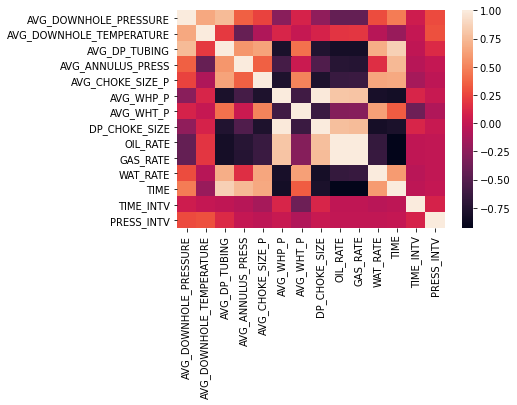

In [7]:
corr = Data.corr()
#corr_data = pd.DataFrame(corr)
sns.heatmap(corr)
corr

* We can see the linear relationship between the OIL and GAS rates using the scatter plot. 

Text(0, 0.5, 'Gas rate')

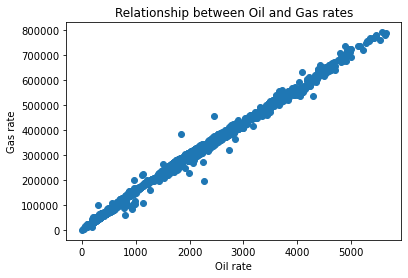

In [6]:
plt.scatter(Data['OIL_RATE'], Data['GAS_RATE'])
plt.title('Relationship between Oil and Gas rates')
plt.xlabel('Oil rate')
plt.ylabel('Gas rate')

* They even share the same distribution, normal distribution with some outliers in the same levels. 
We can conclude that the prediction of one variable implies the other.

<AxesSubplot:>

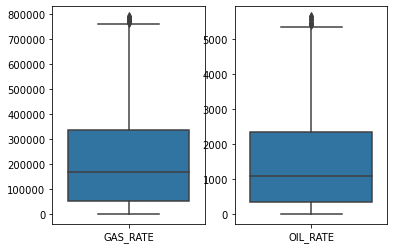

In [7]:
plt.subplot(1, 2, 1)
sns.boxplot( data=Data, order= ['GAS_RATE'])

plt.subplot(1, 2, 2)
sns.boxplot( data=Data, order= ['OIL_RATE'])

#### Predictors relationship with the target variables: 

* In order to avoid multicollinearity, we compare the correlation between features and remove one of two features that have a correlation higher than 0.9


In [8]:
datafeatures = Data.drop(['OIL_RATE', 'GAS_RATE', 'WAT_RATE'], axis = 'columns', inplace = False)
corr = datafeatures.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
print(columns)
selected_columns = datafeatures.columns[columns]
newdata = datafeatures[selected_columns]
newdata['Time'] = Data['TIME']
newdata['OIL_RATE'] = Data['OIL_RATE'] 
newdata['GAS_RATE'] = Data['GAS_RATE'] 
newdata['WAT_RATE'] = Data['WAT_RATE']


[ True  True  True  True  True  True  True False  True  True  True]


In [9]:
columns

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True])

In [9]:
newdata.shape

(2722, 12)

### Data Structure: 
* We prepare the data so it can be fed into the neural network models. We'll check first the dimension of the features and targets data. 

In [10]:
newdata.head()
newdata = newdata.dropna()
newdata.shape

(2224, 12)

In [11]:
X = newdata.iloc[:,:-3].values
print('the features data X is of dimension', X.shape)
Y = newdata.iloc[:,-3:].values
print('the targets data Y is of dimension', Y.shape)

the features data X is of dimension (2224, 9)
the targets data Y is of dimension (2224, 3)


In [12]:
newdata.iloc[:,:-3]

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,TIME,Time
0,260.866875,103.292880,160.151955,0.000000,21.052993,100.714919,52.381899,0,0
1,256.248230,104.017718,156.649912,0.000000,27.223459,99.598318,71.115352,1,1
2,254.982785,103.967009,156.332844,0.000000,27.277954,98.649941,67.590753,2,2
3,251.475921,104.210557,155.817187,0.000000,30.650552,95.658734,73.782251,3,3
4,249.346191,104.339184,155.760939,0.000000,32.562537,93.585252,78.035440,4,4
...,...,...,...,...,...,...,...,...,...
2717,268.812764,100.295456,239.081167,23.646426,82.190685,29.731597,87.864056,2918,2918
2718,265.922630,100.338436,238.398367,23.980052,100.000000,27.524263,89.153704,2919,2919
2719,267.768521,100.320956,238.638669,23.935044,91.162324,29.129852,89.074774,2920,2920
2720,266.002483,100.345865,238.273904,24.058641,100.000000,27.728579,89.503524,2921,2921


* The LSTM model input dimension requires the third dimension that will be the number of the single input row. We'll reshape the X data 

In [13]:
X = X.reshape(X.shape[0], X.shape[1], 1)

* Then we will define the input and output data dimensions from X and Y data.

In [14]:
input_dimension  = (X.shape[1], X.shape[2])
output_dimension = Y.shape[1]

* We can split the data into the train, test and validation parts; 70% of the data for training set and the remaining 30% for the testing and validation sets.

In [15]:
X, Xtest, Y, Ytest = train_test_split(X,Y,test_size=0.15,train_size=0.85)
Xtrain, Xval, Ytrain, Yval = train_test_split(X,Y,test_size = 0.15,train_size =0.7)

## Modeling

* We will build two neural networks architectures to predict the triplet (OIL_RATE, GAS_RATE, WAT_RATE). 


#### 1. LSTM Model: 

* We will start by defining the sequential model. The sequential model contains LSTM layers with ReLU activations, Dense output layer,  and Adam optimizer with MSE loss function. We will set the input dimension in the first layer and output dimension in the last layer of the model.
* Then, we will fit the model with train data.


In [16]:
from keras import optimizers

#optimizer = optimizers.Adam(clipvalue=1.e-10)

model = Sequential()
model.add(LSTM(64, input_shape=input_dimension, activation="relu"))
model.add(Dense(output_dimension))
model.compile(loss="mse", optimizer="adam") 
#model.compile(loss="mse", optimizer=optimizer) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 17,091
Trainable params: 17,091
Non-trainable params: 0
_________________________________________________________________


#### Testing Overfitting and Underfitting: 
* To test if our model overfitting or underfitted on the data sample, we use the traning and validation sets 
* Based on the loss function plot of  training and validation sets, we can notice that the loss decreases until the 60th epoch

Train on 1323 samples, validate on 284 samples
Epoch 1/100
1323/1323 [==============================] - 2s 2ms/step - loss: 8472076321.6327 - val_loss: 6128111414.7606
Epoch 2/100
1323/1323 [==============================] - 2s 1ms/step - loss: 6151780369.1247 - val_loss: 4747814732.6197
Epoch 3/100
1323/1323 [==============================] - 2s 1ms/step - loss: 3756987152.7861 - val_loss: 1387466711.9155
Epoch 4/100
1323/1323 [==============================] - 2s 1ms/step - loss: 2112410421.4724 - val_loss: 1441196999.3803
Epoch 5/100
1323/1323 [==============================] - 2s 1ms/step - loss: 1695593619.4928 - val_loss: 965994054.3380
Epoch 6/100
1323/1323 [==============================] - 2s 1ms/step - loss: 1357345752.8980 - val_loss: 1514081819.1549
Epoch 7/100
1323/1323 [==============================] - 2s 1ms/step - loss: 1464917639.2305 - val_loss: 1405357127.1549
Epoch 8/100
1323/1323 [==============================] - 2s 1ms/step - loss: 1349471795.9244 - val_loss: 11

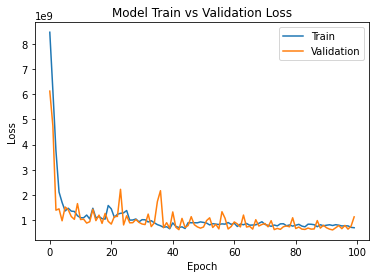

In [17]:
history = model.fit(Xtrain, Ytrain, epochs=100,batch_size=5, validation_data=(Xval, Yval), verbose=1)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Train vs Validation Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper right')
pyplot.show()

* We train the model and then we test it on the testing data.

In [18]:
model = Sequential()
model.add(LSTM(64, input_shape=input_dimension, activation="relu"))
model.add(Dense(output_dimension))
model.compile(loss="mse", optimizer="adam") 
model.summary()
model.fit(Xtrain, Ytrain, epochs=60, batch_size=5, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 17,091
Trainable params: 17,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
1323/1323 [==============================] - 2s 1ms/step - loss: 8067362459.8881
Epoch 2/60
1323/1323 [==============================] - 1s 1ms/step - loss: 5399716366.0287
Epoch 3/60
1323/1323 [==============================] - 2s 1ms/step - loss: 4497678956.2509
Epoch 4/60
1323/1323 [==============================] - 2s 1ms/step - loss: 2502818518.8692
Epoch 5/60
1323/1323 [==============================] - 2s 1ms/step - loss: 2043467204.9947
Epoch 6/60
1323/1323 [==============================

#### Results prediction and visualization :

* We will predict test data and we check the mean squared error (MSE), the relative squared error (RSE) and the relative abolute error (RAE).

In [19]:
Predictions = model.predict(Xtest)

* We plot the result of predictions in the following graph: 

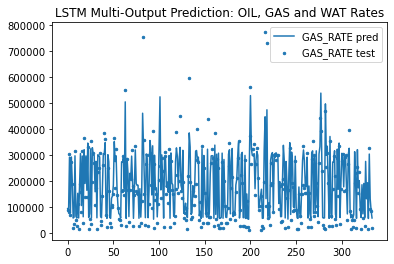

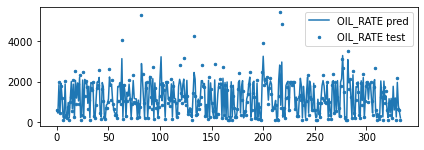

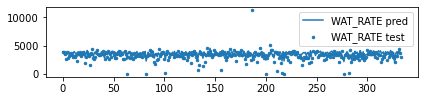

In [20]:
axis = range(len(Xtest))
plt.subplot(1, 1, 1)
plt.title("LSTM Multi-Output Prediction: OIL, GAS and WAT Rates")
plt.scatter(axis, Ytest[:,1],  s=6, label="GAS_RATE test")
plt.plot(axis, Predictions[:,1], label="GAS_RATE pred")

plt.legend()
plt.show()

plt.subplot(2, 1, 1)
plt.scatter(axis, Ytest[:,0],  s=6, label="OIL_RATE test")
plt.plot(axis, Predictions[:,0], label="OIL_RATE pred")

plt.legend()
plt.tight_layout()

plt.show()

plt.subplot(3, 1, 1)
plt.scatter(axis, Ytest[:,2],  s=6, label="WAT_RATE test")
plt.plot(axis, Predictions[:,2], label="WAT_RATE pred")

plt.legend()
plt.tight_layout()

plt.show()

##### 1. Relative absolute error metric

In [21]:
def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error """
    return np.sum(np.abs(actual - predicted)) / np.sum(np.abs(actual - np.mean(actual)))

def rse(actual, predicted):
    """ Relative Squared Error """
    return np.sum((predicted - actual)**2) / np.sum((actual - np.mean(actual))**2)

print("Relative Absolute Error metric using LSTM model")

print("OIL_RATE RAE:%.4f" % rae(Ytest[:,0], Predictions[:,0]))
print("GAS_RATE RAE:%.4f" % rae(Ytest[:,1], Predictions[:,1])) 
print("WAT_RATE RAE:%.4f" % rae(Ytest[:,2], Predictions[:,2]))

print('\n')
print("Relative Squared Error metric using LSTM model")

print("OIL_RATE RSE:%.4f" % rse(Ytest[:,0], Predictions[:,0]))
print("GAS_RATE RSE:%.4f" % rse(Ytest[:,1], Predictions[:,1])) 
print("WAT_RATE RSE:%.4f" % rse(Ytest[:,2], Predictions[:,2]))

Relative Absolute Error metric using LSTM model
OIL_RATE RAE:0.3525
GAS_RATE RAE:0.3921
WAT_RATE RAE:1.1068


Relative Squared Error metric using LSTM model
OIL_RATE RSE:0.2026
GAS_RATE RSE:0.2038
WAT_RATE RSE:0.9898


#### 2. GRU Model
* We apply MinMaxSclaer on the data so the high values would not take more attention than the others. 
* Based on the history plot, we set the epoch parameter to 35

Train on 1323 samples, validate on 284 samples
Epoch 1/100
1323/1323 [==============================] - 2s 2ms/step - loss: 0.0209 - val_loss: 0.0068
Epoch 2/100
1323/1323 [==============================] - 2s 2ms/step - loss: 0.0069 - val_loss: 0.0043
Epoch 3/100
1323/1323 [==============================] - 2s 2ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 4/100
1323/1323 [==============================] - 2s 2ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 5/100
1323/1323 [==============================] - 2s 2ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 6/100
1323/1323 [==============================] - 2s 2ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 7/100
1323/1323 [==============================] - 2s 2ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 8/100
1323/1323 [==============================] - ETA: 0s - loss: 0.003 - 2s 2ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/100
1323/1323 [==============================] - 2s 2ms/step - loss: 0.0034 - val_loss: 0.0033
Ep

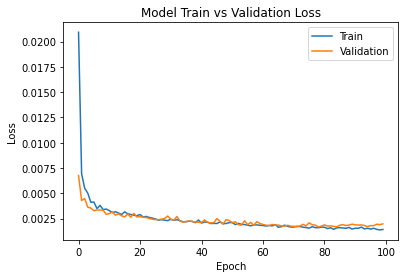

In [22]:
scaleddata = newdata.iloc[:,:-3].values

scaler_x = MinMaxScaler()
scaler_y= MinMaxScaler()

x = scaler_x.fit_transform(newdata.iloc[:,:-3].values)
y = scaler_y.fit_transform(newdata.iloc[:,-3:].values)
x = x.reshape(x.shape[0], x.shape[1], 1)

X, Xtest, Y, Ytest = train_test_split(x,y,test_size=0.15,train_size=0.85)
Xtrain, Xval, Ytrain, Yval = train_test_split(X,Y,test_size = 0.15,train_size =0.7)

model = Sequential()
model.add(GRU(units=50, input_shape=Xtrain.shape[1:], return_sequences=False))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(output_dimension))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(Xtrain, Ytrain, batch_size=5, validation_data=(Xval, Yval), epochs=100)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Train vs Validation Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper right')
pyplot.show()

In [23]:
model = Sequential()
model.add(GRU(units=50, input_shape=Xtrain.shape[1:], return_sequences=False))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(output_dimension))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(Xtrain, Ytrain, batch_size=5, epochs=35, verbose=0)

predictions = model.predict(Xtest)

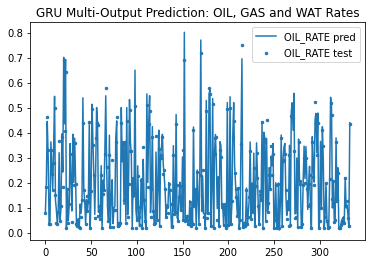

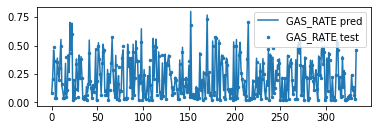

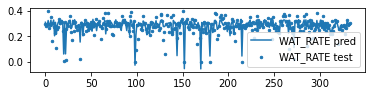

In [31]:
axis = range(len(Xtest))
plt.subplot(1, 1, 1)
plt.title("GRU Multi-Output Prediction: OIL, GAS and WAT Rates")
plt.scatter(axis, Ytest[:,0],  s=6, label="OIL_RATE test")
plt.plot(axis, predictions[:,0], label="OIL_RATE pred")


plt.legend()
plt.show()
plt.subplot(2, 1, 1)
plt.scatter(axis, Ytest[:,1],  s=6, label="GAS_RATE test")
plt.plot(axis, predictions[:,1], label="GAS_RATE pred")
plt.legend()
plt.show()

plt.subplot(3, 1, 1)
plt.scatter(axis, Ytest[:,2],  s=6, label="WAT_RATE test")
plt.plot(axis, predictions[:,2], label="WAT_RATE pred")
plt.legend()
plt.show()

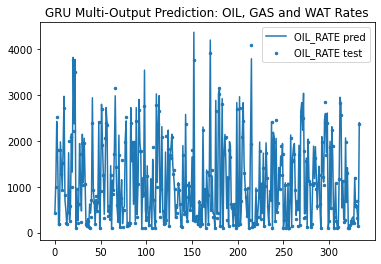

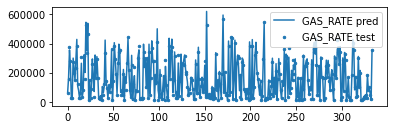

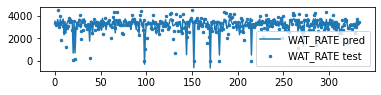

In [30]:
Predictionsinversed = scaler_y.inverse_transform(predictions)
Ytestinversed = scaler_y.inverse_transform(Ytest)

axis = range(len(Xtest))
plt.subplot(1, 1, 1)
plt.title("GRU Multi-Output Prediction: OIL, GAS and WAT Rates")
plt.scatter(axis, Ytestinversed[:,0],  s=6, label="OIL_RATE test")
plt.plot(axis, Predictionsinversed[:,0], label="OIL_RATE pred")



plt.legend()
plt.show()
plt.subplot(2, 1, 1)
plt.scatter(axis, Ytestinversed[:,1],  s=6, label="GAS_RATE test")
plt.plot(axis, Predictionsinversed[:,1], label="GAS_RATE pred")
plt.legend()
plt.show()

plt.subplot(3, 1, 1)
plt.scatter(axis, Ytestinversed[:,2],  s=6, label="WAT_RATE test")
plt.plot(axis, Predictionsinversed[:,2], label="WAT_RATE pred")
plt.legend()
plt.show()

In [26]:
print("Relative Absolute Error metric using GRU model")

print("OIL_RATE RAE:%.4f" % rae(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RAE:%.4f" % rae(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RAE:%.4f" % rae(Ytestinversed[:,2], Predictionsinversed[:,2]))

print('\n')
print("Relative Squared Error metric using GRU model")

print("OIL_RATE RSE:%.4f" % rse(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RSE:%.4f" % rse(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RSE:%.4f" % rse(Ytestinversed[:,2], Predictionsinversed[:,2]))

Relative Absolute Error metric using GRU model
OIL_RATE RAE:0.1442
GAS_RATE RAE:0.1477
WAT_RATE RAE:0.6119


Relative Squared Error metric using GRU model
OIL_RATE RSE:0.0398
GAS_RATE RSE:0.0420
WAT_RATE RSE:0.3678


* After including the scaling processing and building a GRU architecture, we get a high quality predictions with minimal errors. We run the LSTM model on the scaled data to see if we can get accurate results using the LSTM neural network.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 17,091
Trainable params: 17,091
Non-trainable params: 0
_________________________________________________________________
Train on 1323 samples, validate on 284 samples
Epoch 1/100
1323/1323 [==============================] - 2s 1ms/step - loss: 0.0151 - val_loss: 0.0106
Epoch 2/100
1323/1323 [==============================] - 2s 1ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 3/100
1323/1323 [==============================] - 2s 1ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 4/100
1323/1323 [==============================] - 2s 1ms/step - loss: 0.0041 - val_loss: 0.0067
Epoch 5/100
1323/1323 [==============================

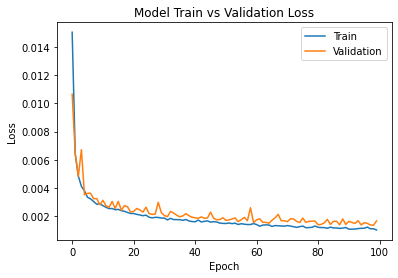

In [27]:
model = Sequential()
model.add(LSTM(64, input_shape=input_dimension, activation="relu"))
model.add(Dense(output_dimension))
model.compile(loss="mse", optimizer="adam") 
model.summary()
history = model.fit(Xtrain, Ytrain, batch_size=5, validation_data=(Xval, Yval), epochs=100)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Train vs Validation Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper right')
pyplot.show()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 17,091
Trainable params: 17,091
Non-trainable params: 0
_________________________________________________________________


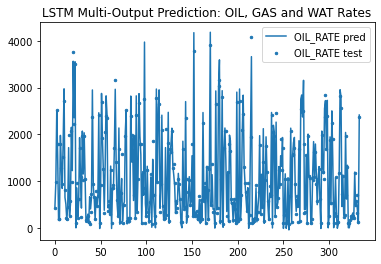

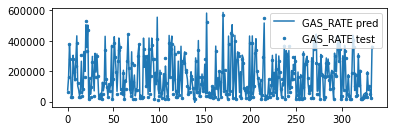

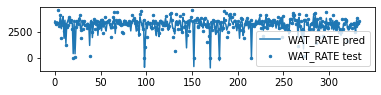

In [32]:
model = Sequential()
model.add(LSTM(64, input_shape=input_dimension, activation="relu"))
model.add(Dense(output_dimension))
model.compile(loss="mse", optimizer="adam") 
model.summary()
history = model.fit(Xtrain, Ytrain, batch_size=5, epochs=40, verbose = 0)
predictionsLSTM = model.predict(Xtest)

Predictionsinversed = scaler_y.inverse_transform(predictionsLSTM)
Ytestinversed = scaler_y.inverse_transform(Ytest)

axis = range(len(Xtest))
plt.subplot(1, 1, 1)
plt.title("LSTM Multi-Output Prediction: OIL, GAS and WAT Rates")
plt.scatter(axis, Ytestinversed[:,0],  s=6, label="OIL_RATE test")
plt.plot(axis, Predictionsinversed[:,0], label="OIL_RATE pred")


plt.legend()
plt.show()
plt.subplot(2, 1, 1)
plt.scatter(axis, Ytestinversed[:,1],  s=6, label="GAS_RATE test")
plt.plot(axis, Predictionsinversed[:,1], label="GAS_RATE pred")
plt.legend()
plt.show()
plt.subplot(3, 1, 1)
plt.scatter(axis, Ytestinversed[:,2],  s=6, label="WAT_RATE test")
plt.plot(axis, Predictionsinversed[:,2], label="WAT_RATE pred")

plt.legend()
plt.show()

In [29]:
print("Relative Absolute Error metric using LSTM model")

print("OIL_RATE RAE:%.4f" % rae(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RAE:%.4f" % rae(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RAE:%.4f" % rae(Ytestinversed[:,2], Predictionsinversed[:,2]))

print('\n')
print("Relative Squared Error metric using LSTM model")

print("OIL_RATE RSE:%.4f" % rse(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RSE:%.4f" % rse(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RSE:%.4f" % rse(Ytestinversed[:,2], Predictionsinversed[:,2]))

Relative Absolute Error metric using LSTM model
OIL_RATE RAE:0.1406
GAS_RATE RAE:0.1616
WAT_RATE RAE:0.7584


Relative Squared Error metric using LSTM model
OIL_RATE RSE:0.0406
GAS_RATE RSE:0.0409
WAT_RATE RSE:0.4900


## Conclusion (HAS NOT BEEN REVISED): 

We can assume that scaling the data is a crucial step the data preprocessing. Both of the models give good results after scaling using MinMaxScaler() function. However, we can notice that GRU results are slightly better than LSTM model especially if we compare RAE metric. 

1. Relative Absolute Error metric:

LSTM model
    - OIL_RATE RAE:0.5595
    - GAS_RATE RAE:0.5285
    - WAT_RATE RAE:0.1670


GRU model
    - OIL_RATE RAE:0.4654
    - GAS_RATE RAE:0.4729
    - WAT_RATE RAE:0.1730




2. Relative Squared Error metric: 

LSTM model
    - OIL_RATE RSE:0.3873
    - GAS_RATE RSE:0.3645
    - WAT_RATE RSE:0.1056

GRU model
    - OIL_RATE RSE:0.2918
    - GAS_RATE RSE:0.3242
    - WAT_RATE RSE:0.1055